### Model tuning setup

In [1]:
#%store -r training_data
#%store -r training_columns
#%store -r bkg_df
#%store -r mc_df
#%store -r data_df

In [2]:
#@title
#!pip install uproot
#!pip install sklearn

import time

import numpy as np
import pandas as pd
import uproot
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, train_test_split)
from xgboost.sklearn import XGBClassifier

/tmp/ipykernel_4644/1411477585.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Time and processing check for the lesson
stt = time.time()
stc = time.process_time()

In [4]:
def plot_mass(df, label="", norm=True):
    counts, bins, _ = plt.hist(df['Jpsi_M'], label=label, bins=100, range=[2.75, 3.5], histtype='step', density=norm)
    # You can also use LaTeX in the axis label
    plt.xlabel('$J/\\psi$ mass [GeV]')
    plt.xlim(bins[0], bins[-1])

In [5]:
def plot_comparision(var, mc_df, bkg_df):
    _, bins, _ = plt.hist(mc_df[var], bins=100, histtype='step', label='MC', density=1)
    _, bins, _ = plt.hist(bkg_df[var], bins=bins, histtype='step', label='Background', density=1)
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')

In [6]:
def plot_roc(bdt, training_data, training_columns, label=None):
    y_score = bdt.predict_proba(training_data[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)
    area = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    if label:
        plt.plot(fpr, tpr, label=f'{label} (area = {area:.2f})')
    else:
        plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    # We can make the plot look nicer by forcing the grid to be square
    plt.gca().set_aspect('equal', adjustable='box')

In [7]:
def plot_significance(bdt, training_data, training_columns, label):
    y_score = bdt.predict_proba(training_data[training_columns])[:,1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

    n_sig = 1200
    n_bkg = 23000
    S = n_sig*tpr + (n_sig*tpr==0)*1
    B = n_bkg*fpr + (n_bkg*tpr==0)*1
    metric = S/np.sqrt(S+B)

    plt.plot(thresholds, metric, label=label)
    plt.xlabel('BDT cut value')
    plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
    plt.xlim(0, 1.0)

    optimum = np.max(metric)
    optimal_cut = thresholds[np.argmax(metric)]
    print(label, ":  S/sqrt(S+B) =", optimum, " at x =", optimal_cut)
    plt.axvline(x=optimal_cut, color='black', linewidth=1.0, linestyle='--')

    return optimal_cut

In [8]:
#max_entries = 1000 # try running with low stats for bug fixing your changes quickly
data_df = uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/real_data.root',
                    httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                    )['DecayTree'].arrays(library='pd')#,entry_stop=max_entries)
mc_df = uproot.open('https://cern.ch/starterkit/data/advanced-python-2018/simulated_data.root',
                    httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                    )['DecayTree'].arrays(library='pd')#,entry_stop=max_entries)
bkg_df = data_df.query('~(3.0 < Jpsi_M < 3.2)')

for df in [mc_df, data_df, bkg_df]:
    df.eval('Jpsi_eta = arctanh(Jpsi_PZ/Jpsi_P)', inplace=True)
    df.eval('mup_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
    df.eval('mum_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)

bkg_df['catagory'] = 0  # Use 0 for background
mc_df['catagory'] = 1  # Use 1 for signal
training_data = pd.concat([bkg_df, mc_df], copy=True, ignore_index=True)
for df in [mc_df, bkg_df, data_df, training_data]:
    df['IPdiff'] = np.abs(df['mum_PT'] - df['mup_PT'])

training_columns = [
    'Jpsi_PT',
    'mup_PT', 'mup_eta', 'mup_ProbNNmu', 'mup_IP',
    'mum_PT', 'mum_eta', 'mum_ProbNNmu', 'mum_IP',
]

/tmp/ipykernel_4644/2007768199.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.eval('Jpsi_eta = arctanh(Jpsi_PZ/Jpsi_P)', inplace=True)
/tmp/ipykernel_4644/2007768199.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.eval('mup_P = sqrt(mum_PX**2 + mum_PY**2 + mum_PZ**2)', inplace=True)
/tmp/ipykernel_4644/2007768199.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Previously we trained an XGBClassifier with the default settings, with learning rate = 0.3 and maximum iterations = 100. This cut off to the training process may be limiting the performance of our model. We can monitor the performance of our model as a function of training iteration and stop the training when the gradient approximates zero. 

In [9]:
X1, y1 = training_data[training_columns], training_data['catagory']
X_train, X_test, y_train, y_test = train_test_split(X1, y1)
# default train_size = 0.25, this can be varied to suit your data

LR = 0.3 # the coefficient of step size decay, eta, has alias 'learning_rate' with default 0.3

stime = time.time()
bdt = XGBClassifier(learning_rate = LR, n_estimators=100, seed=123, n_jobs=-1)
bdt.fit(training_data[training_columns], training_data['catagory'])
print("XGBoost --- %s seconds ---" % (time.time() - stime))

for df in [mc_df, bkg_df, data_df, training_data]:
    df['XGB'] = bdt.predict_proba(df[training_columns])[:,1]

XGBoost --- 0.8518712520599365 seconds ---


/tmp/ipykernel_4644/3009250180.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['XGB'] = bdt.predict_proba(df[training_columns])[:,1]


### Cross-validation

Splitting the data into randomised subsets for training allows you to monitor your model's performance on the fly using the statistically independant remainder of your sample - this is called cross-validation (CV). We can see below that at the 100th iteration the metrics still show a trend of improvement.

In [10]:
def training_monitor(alg):

  # A model trained with eval_set and eval_metric will return evals_result
  results = alg.evals_result()
  epochs = len(results['validation_0']['logloss'])
  x_axis = range(0, epochs)

  # Plotting logLoss as a function of training iteration
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0']['logloss'], label='Train') # for each eval_set
  if results['validation_1']: ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
  ax.legend()
  plt.ylabel('LogLoss')
  plt.title('LogLoss')
  plt.show()

  # Plotting classification error as a function of training iteration
  fig, ax = plt.subplots()
  ax.plot(x_axis, results['validation_0']['error'], label='Train')  # for each eval_set
  if results['validation_1']: ax.plot(x_axis, results['validation_1']['error'], label='Test')
  ax.legend()
  plt.ylabel('Error')
  plt.title('Error')
  plt.show()

This involves training on less data but allows us to monitor progress to check if the model is becoming over-specific to our training sample. The minimisation of loss and classification error are common metrics for model assessment. As shown below, the cost to performance is negligible. If the test sample gradient were to invert this would be considered overtraining and is why monitoring performance without CV can be a time costly pitfall.

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:14:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_threads" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost cross-validation --- 1.9497551918029785 seconds ---


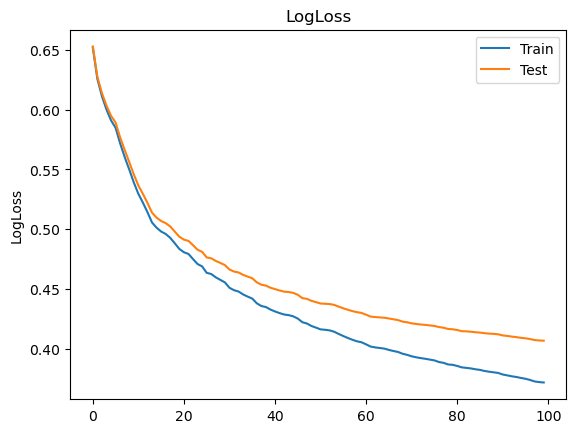

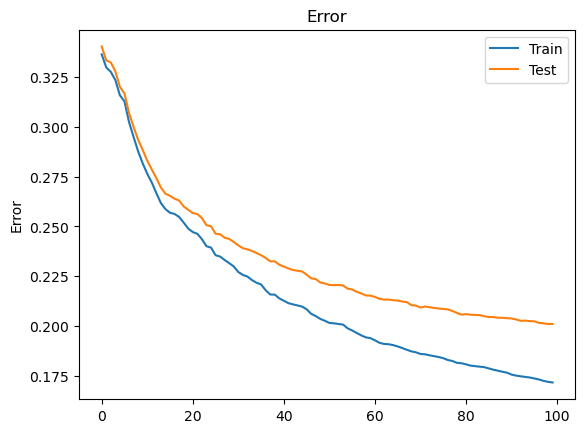

/tmp/ipykernel_4644/3553768138.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['XGBcv'] = bdt_cv.predict_proba(df[training_columns])[:,1]


In [11]:
# Defining a model with multi-threading set to maximum
bdt_cv = XGBClassifier(learning_rate = LR, n_estimators=100, seed=123, n_threads=-1)

# Model fitting with CV and printing out processing time
stime = time.time()
bdt_cv.fit(X_train, y_train, eval_metric=["logloss","error"],
           eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
print("\nXGBoost cross-validation --- %s seconds ---" % (time.time() - stime))

# Writing model predictions out for data
training_monitor(bdt_cv)
for df in [mc_df, bkg_df, data_df, training_data]:
    df['XGBcv'] = bdt_cv.predict_proba(df[training_columns])[:,1]

bdt :  S/sqrt(S+B) = 15.405805978293522  at x = 0.80857503


bdt_cv :  S/sqrt(S+B) = 15.364206707574938  at x = 0.8245125


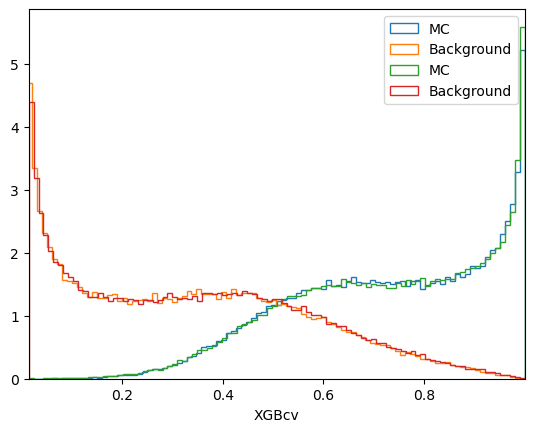

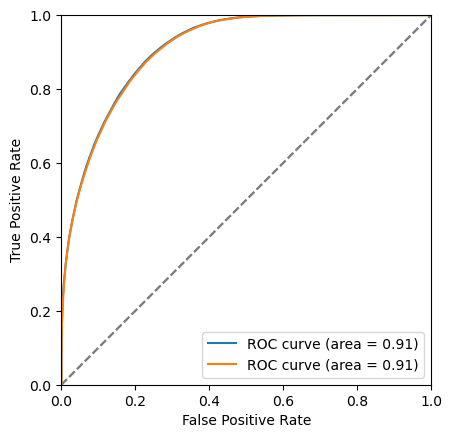

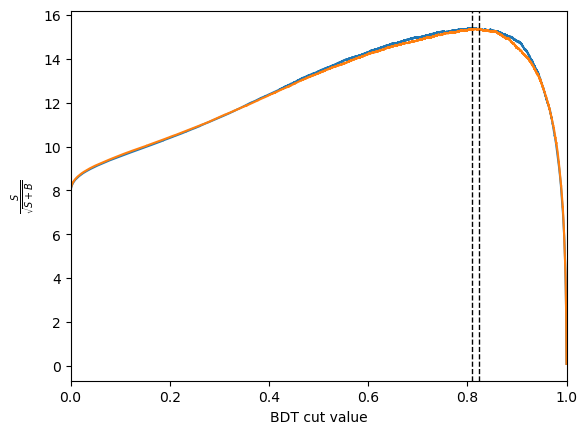

In [12]:
# Drawing plot of model respone for signal and background classes
plt.figure()
plot_comparision('XGB', mc_df, bkg_df)
plot_comparision('XGBcv', mc_df, bkg_df)

# Drawing the signal efficiency vs background rejection curve (ROC)
plt.figure()
plot_roc(bdt, training_data, training_columns)
plot_roc(bdt_cv, training_data, training_columns)

# Drawing signal significance comparison as a function of minimum cut on model response
plt.figure()
bdt_cut = plot_significance(bdt, training_data, training_columns, "bdt")
bdt_cv_cut = plot_significance(bdt_cv, training_data, training_columns, "bdt_cv")

### $k$-folding & early stopping

Performing CV on each of a number, k, of ways to split your data gives you k models to choose from. Some choose to average the performance across the models from each fold as any instability might imply the model will not be reliable. The results below seem stable; each fold provides a consistant performance across multiple metrics, so we'll just choose the best one.

In [13]:
# Defining the folds with a seed to test consistently
splits = 4 # to match 0.25 value of test_train_split default though this may not be optimal
kf = KFold(n_splits=splits, shuffle=True, random_state=123)

# Printing processing time of the kfold cross-validation
stime = time.time()
for train, test in kf.split(X1):
    X_train, X_test = X1.iloc[train], X1.iloc[test]
    y_train, y_test = y1.iloc[train], y1.iloc[test]
    bdt.fit(X_train,y_train)
print("\nXGBoost k-folding --- %s seconds ---" % (time.time() - stime))

# Calculating scores of each fold using variety of CV-metrics
cv_acc = cross_val_score(bdt, X_test, y_test, cv=splits, scoring="accuracy", n_jobs=-1)
cv_los = cross_val_score(bdt, X_test, y_test, cv=splits, scoring="neg_log_loss", n_jobs=-1)
cv_auc = cross_val_score(bdt, X_test, y_test, cv=splits, scoring="roc_auc", n_jobs=-1)

# Printing results and indicating best fold
print("accuracy: ",cv_acc, " ->  best fold =", np.argmax(cv_acc) )
print("-logloss: ",cv_los, " ->  best fold =", np.argmax(cv_los) )
print("roc_auc:  ",cv_auc, " ->  best fold =", np.argmax(cv_auc) )
bestfold = np.argmax(cv_acc)


XGBoost k-folding --- 2.6696691513061523 seconds ---


accuracy:  [0.78412488 0.77760064 0.78477481 0.78856118]  ->  best fold = 3
-logloss:  [-0.42945196 -0.43137575 -0.42765048 -0.42374993]  ->  best fold = 3
roc_auc:   [0.87520356 0.87239133 0.8768386  0.87975731]  ->  best fold = 3


Early stopping defines a maximum number of rounds the cross-validation metric (we'll use 'error'=1-accuracy) is allowed to not improve before training is terminated. As is standard, we will be reverting back to a 'previous best' model based on test sample score, this helps avoid overtraining. Early stopping prevents us training too many of extra models thus saving time. Set the limit too small though and your training might be cut off prematurely.

In [14]:
def modelfit(alg, metric, params, label, predictors, kfold, fbest, early_stop=10):

    # Loading data split inputs providing best fold result
    for k, (train, test) in enumerate(kf.split(params)):
      if (k==fbest):
        X_train, X_test = params.iloc[train], params.iloc[test]
        y_train, y_test = label.iloc[train], label.iloc[test]

    # Defining data in terms of training variables and class label
    xgb_param = alg.get_xgb_params()
    data = xgb.DMatrix(params, label=label, feature_names=predictors, nthread=-1)

    # Runs timed CV on our model using early stopping based on our metric
    stime = time.time()
    cvresult = xgb.cv(xgb_param,
                      data,
                      num_boost_round=alg.get_params()['n_estimators'],
                      #nfold=cv_folds, # to use in build folding
                      folds=kfold, # use -> ignores nfold
                      metrics=metric,
                      early_stopping_rounds=early_stop)
    alg.set_params(n_estimators=cvresult.shape[0])
    print("\nXGBoost early-stop folding --- %s seconds ---" % (time.time() - stime))

    # Fitting the algorithm on the data with CV evaluation early stopping
    stime = time.time()
    alg.fit(X_train, y_train, eval_metric=["logloss","error"],
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False, early_stopping_rounds=early_stop)
    training_monitor(alg)
    print("XGBoost early-stop limit --- %s seconds ---" % (time.time() - stime))

    # Predicting training set:
    train_predictions = alg.predict(X_train)
    test_predictions = alg.predict(X_test)

    # Printing model report:
    print("\nModel Report : best iteration "+str(cvresult.shape[0]))
    print("Train Accuracy : "+str(metrics.accuracy_score(y_train, train_predictions)))
    print("Test Accuracy : "+str(metrics.accuracy_score(y_test, test_predictions)))
    return cvresult.shape[0]

This function incorporates the k-folding CV and early stopping, saving not only the optimal model but also the index of its training iteration. This means, in our subsequent steps, we can apply an upper limit on training for models based on the convergence of the default hyperparameters, saving us some time. 


XGBoost early-stop folding --- 16.12229871749878 seconds ---


/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


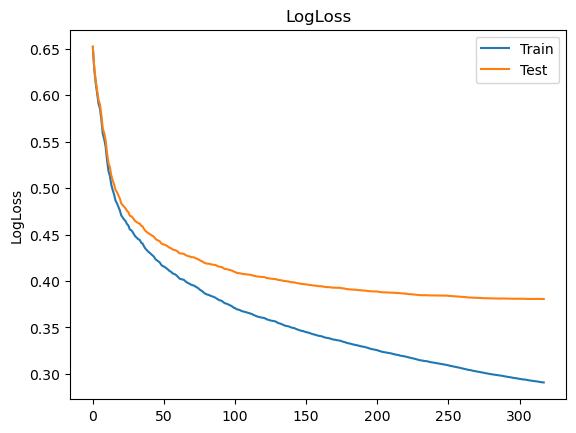

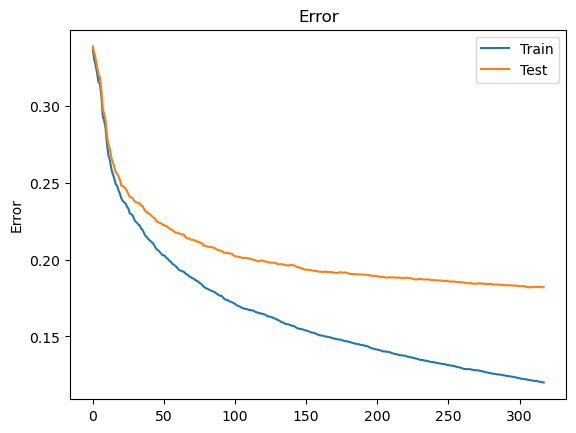

XGBoost early-stop limit --- 5.9259254932403564 seconds ---



Model Report : best iteration 320
Train Accuracy : 0.878406430077885
Test Accuracy : 0.8180580234817411

modelfit(bdt_es) --- 22.667714595794678 seconds ---


/tmp/ipykernel_4644/41647419.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['XGBes'] = bdt_es.predict_proba(df[training_columns])[:,1]


In [15]:
# Defining model with high maximum estimators for use with early stopping
bdt_es = XGBClassifier(learning_rate = LR,   n_estimators=1000,
                       # Default values of other hyperparamters
                       #max_depth=6,          min_child_weight=1,
                       #gamma=0,              subsample=0.8,
                       #colsample_bytree=0.8, scale_pos_weight=1,
                       #objective='binary:logistic', # default for binary classification
                       #objective='mutli:softprob', num_class=3, # for multiclassifiers
                       seed=123, n_jobs=-1)

# Timing the CV using early stopping
stime = time.time()
estimators = modelfit(bdt_es, "error", X1, y1, training_columns, kf, bestfold)
print("\nmodelfit(bdt_es) --- %s seconds ---" % (time.time() - stime))

# Saving model predictions
for df in [mc_df, bkg_df, data_df, training_data]:
    df['XGBes'] = bdt_es.predict_proba(df[training_columns])[:,1]

This provides us with an improved model as well as a benchmark to test against in both performance and training efficiency. When training using new combinations of hyperparameters, the maximum number of estimators from our model report will cut off any new models improving more slowly than our default, while, for more efficient models, the early stopping will kick in.

bdt_cv :  S/sqrt(S+B) = 15.364206707574938  at x = 0.8245125


bdt_es :  S/sqrt(S+B) = 18.05205070820643  at x = 0.7961289


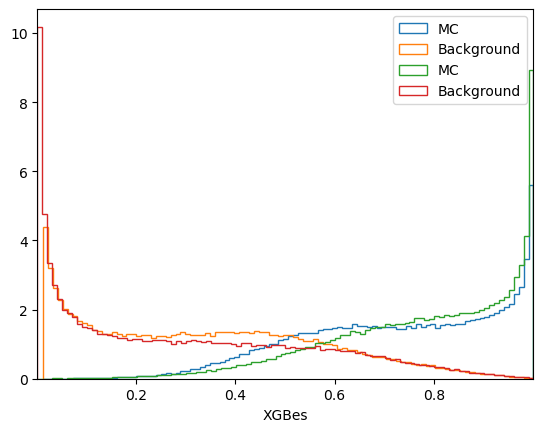

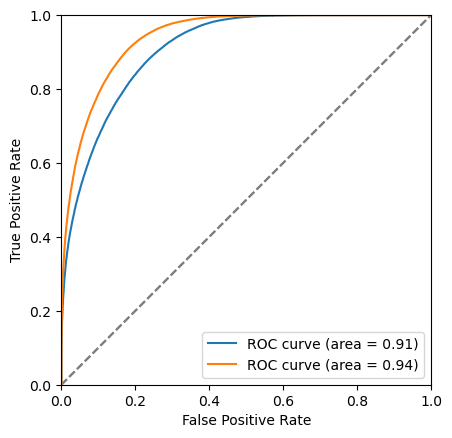

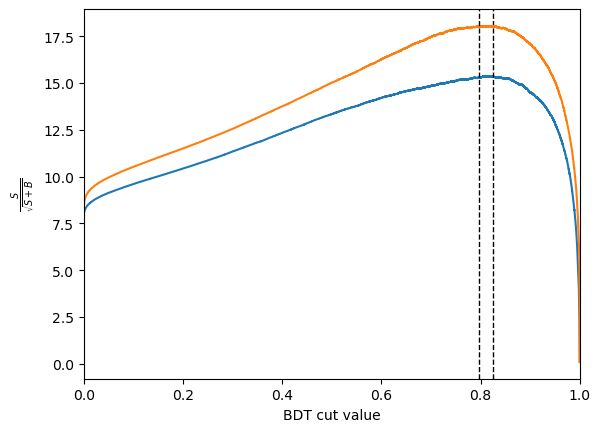

In [16]:
# Drawing plot to compare model response for signal and background classes
plt.figure()
plot_comparision('XGBcv', mc_df, bkg_df)
plot_comparision('XGBes', mc_df, bkg_df)

# Drawing comaprison of the signal efficiency vs background rejection curve (ROC)
plt.figure()
plot_roc(bdt_cv, training_data, training_columns)
plot_roc(bdt_es, training_data, training_columns)

# Drawing signal significance comparison as a function of minimum cut on model response
plt.figure()
bdt_cut_cv = plot_significance(bdt_cv, training_data, training_columns, "bdt_cv")
bdt_cut_es = plot_significance(bdt_es, training_data, training_columns, "bdt_es")

### Hyperameter optimisation

Below we provide a "grid" of hyperparameters, defining the structure of the trees and constraints on the learning, but there are many more values to choose from and a larger parameter space to be explored. These optimsations are very problem specific and their impact will have to be weighed against the computing resources and timeframe you have at your disposal. For the sake of expedient demonstration we are comparing the default parameters to only one predetermined variation in 2 parameters. 

In [17]:
# Define a function that performs a gridscan of HPs


def hpgridscan(alg, metric, params, label, kfold, fbest, early_stop=10):

  # Load data fold with best performance
  for k, (train, test) in enumerate(kf.split(params)):
    if (k==fbest):
      X_train, X_test = params.iloc[train], params.iloc[test]
      y_train, y_test = label.iloc[train], label.iloc[test]

  # Define a dictionary of numpy arrays for our HPs
  params = {
      'max_depth':np.array([7]),
      'min_child_weight':np.array([3]),
      #'max_depth':np.arange(        5,   9,   1   ),
      #'min_child_weight':np.arange( 1,   5,   1   ),
      ##'gamma':np.arange(            0.0, 1.0, 0.1 ),
      ##'colsample_bytree':np.arange( 0.4, 1.0, 0.1 ),
      ##'subsample':np.arange(        0.4, 1.0, 0.1 ),
      ##'scale_pos_weight':np.arange( 0.4, 1.6, 0.1 )
      }

  # Perform timed grid scan with established n_estimator cutoff and early stopping
  stime = time.time()
  gs = GridSearchCV(estimator=alg,
                    param_grid=params,
                    scoring=metric,
                    #iid=False,
                    cv=kf,
                    n_jobs=-1)
  gs.fit(X_train, y_train, eval_metric=["logloss","error"],
         eval_set=[(X_train, y_train), (X_test, y_test)],
         verbose=False, early_stopping_rounds=early_stop)
  print("XGBoost grid-scan --- %s seconds ---" % (time.time() - stime))

  # Return suggested parameters, performance and best model
  training_monitor(gs.best_estimator_)
  print("Suggestion:", gs.best_params_)
  print("Accuracy:" ,gs.best_score_)
  return gs

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is dep

/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/share/miniconda/envs/analysis-essentials/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost grid-scan --- 18.946533203125 seconds ---


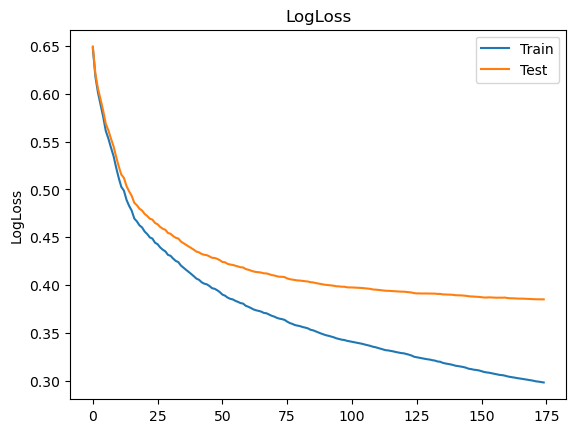

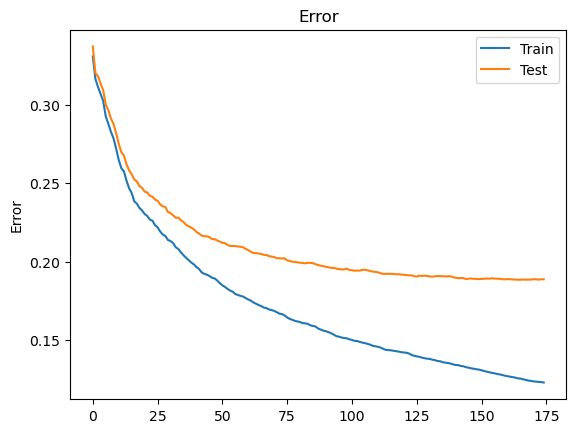

Suggestion: {'max_depth': 7, 'min_child_weight': 3}
Accuracy: 0.8091291887649159

hpgridscan(bdt_st) --- 19.182318449020386 seconds ---


/tmp/ipykernel_4644/1018627576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['XGBgs'] = bdt_gs.predict_proba(df[training_columns])[:,1]


In [18]:
# Running with estimators maximum for shortened training
bdt_st = XGBClassifier( learning_rate = LR, n_estimators=estimators,
                        seed=123,           n_jobs=-1)

# Running timed hyperparameter gridscan
stime = time.time()
gs = hpgridscan(bdt_st, "accuracy", X1, y1, kf, bestfold)
bdt_gs = gs.best_estimator_
print("\nhpgridscan(bdt_st) --- %s seconds ---" % (time.time() - stime))

# Get model predictions
for df in [mc_df, bkg_df, data_df, training_data]:
    df['XGBgs'] = bdt_gs.predict_proba(df[training_columns])[:,1]

Even this naive grid scan, using the same fold as before for fair comparison, can provide significant improvements as demonstrated above. These may be pushed further by including more hyperparameters for a trade off with processing time. However, even with parrallisation these tasks can take hours or longer and might only provide improvement of O(>1%).

In [19]:
## We could define a model using optimal hyperparameters from our grid scan
#bdt_opt = XGBClassifier( learning_rate = LR, n_estimators=1000,
#                         max_depth=gs.best_params_['max_depth'],
#                         min_child_weight=gs.best_params_['min_child_weight'],
#                         seed=123, n_jobs=-1 )

## Run with CV early stopping
#stime = time.time()
#estimators = modelfit(bdt_opt, 'error', X1, y1, training_columns, kf, bestfold)
#print("\nmodelfit(bdt_opt) --- %s seconds ---" % (time.time() - stime))

## Get model predictions
#for df in [mc_df, bkg_df, data_df, training_data]:
#    df['XGBopt'] = bdt_opt.predict_proba(df[training_columns])[:,1]

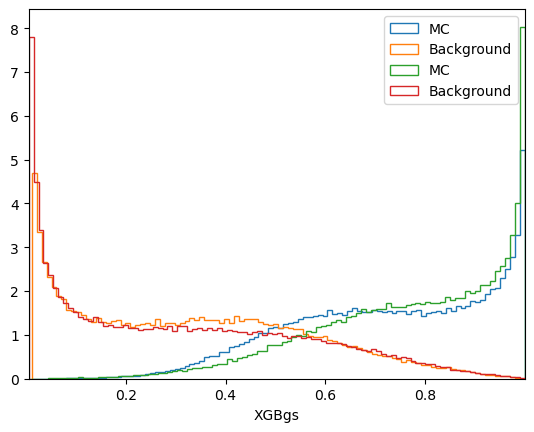

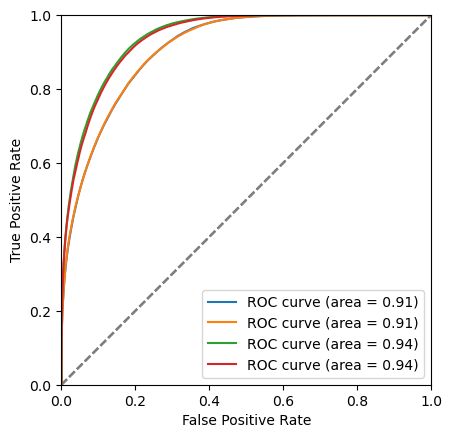

In [20]:
# Comapring model response from the end of last session to the end of this one
plt.figure()
plot_comparision('XGB', mc_df, bkg_df)
plot_comparision('XGBgs', mc_df, bkg_df)

# Comparing model performance for each level of tuning
plt.figure()
plot_roc(bdt, training_data, training_columns)
plot_roc(bdt_cv, training_data, training_columns)
plot_roc(bdt_es, training_data, training_columns)
plot_roc(bdt_gs, training_data, training_columns)
#plot_roc(bdt_opt, training_data, training_columns)

bdt :  S/sqrt(S+B) = 15.225756452547515  at x = 0.8237634


bdt_cv :  S/sqrt(S+B) = 15.364206707574938  at x = 0.8245125


bdt_es :  S/sqrt(S+B) = 18.05205070820643  at x = 0.7961289


bdt_gs :  S/sqrt(S+B) = 17.817070520310462  at x = 0.8272739


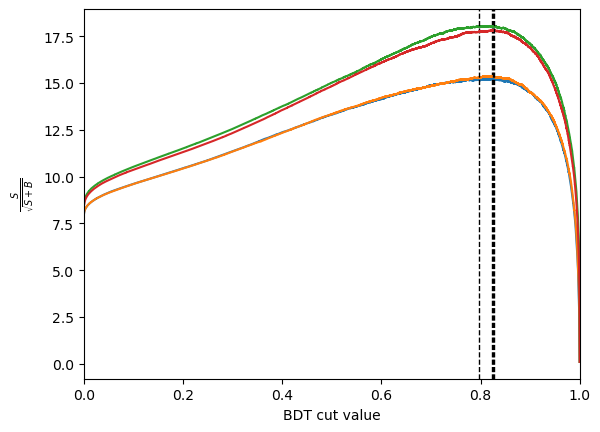

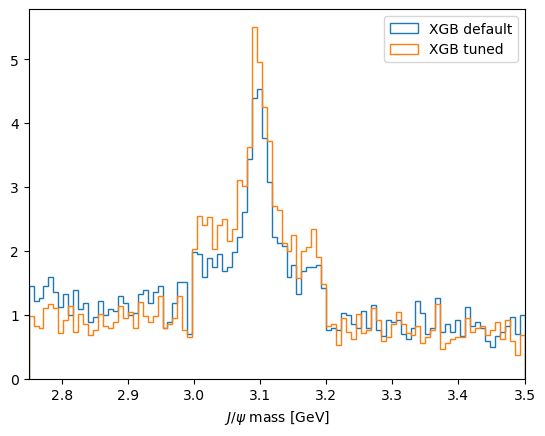

In [21]:
# Comparing the impact on projected performance at each stage of the tutorial
plt.figure()
bdt_cut = plot_significance(bdt, training_data, training_columns, "bdt")
bdt_cv_cut = plot_significance(bdt_cv, training_data, training_columns, "bdt_cv")
bdt_es_cut = plot_significance(bdt_es, training_data, training_columns, "bdt_es")
bdt_gs_cut = plot_significance(bdt_gs, training_data, training_columns, "bdt_gs")
#bdt_opt_cut = plot_significance(bdt_opt, training_data, training_columns, "bdt_opt")

# Comparing best cuts impact on mass for original and tuned model
plt.figure()
data_bdt_cut = data_df.query('XGB > %f' %bdt_cut )
plot_mass(data_bdt_cut, label='XGB default', norm=True)
data_gs_cut = data_df.query('XGBgs > %f' %bdt_gs_cut )
plot_mass(data_gs_cut, label='XGB tuned', norm=True)
plt.legend(loc='best')

Comparing our data sample's mass plot having applied the cut optimised for $\sigma=\frac{S}{\sqrt{S+B}}$ from each BDT output, we can see how the improved model reduces relative background. However, while we define our signal training sample from MC you'll remember we defined our background training sample from the data !(3.0 < JPsi_M < 3.2).

We can see shoulders at the edges of the regions where we define our background training sample in our data's mass spectrum now. Our training and validation samples include a subset of our data sample so there's potential that our model is learning the difference between MC and data and exploiting that or demonstrating overtraining on the 'previously seen' data (remember we could see our train and test samples beginning to diverge in our validation metrics with more iterations).

Below you can see replotting the normalised mass distribution from just the data not included in training demonstrates no significant improvement. This is not ideal and might be addressed by choosing the setup of our training more carefully. For example, we could train using background from same-sign muon MC across the full mass range (a common practice in LHC experiments) or, using other libraries such as UGBoost to introduce a punishment to the training for introducing a depedance of efficiency on mass.

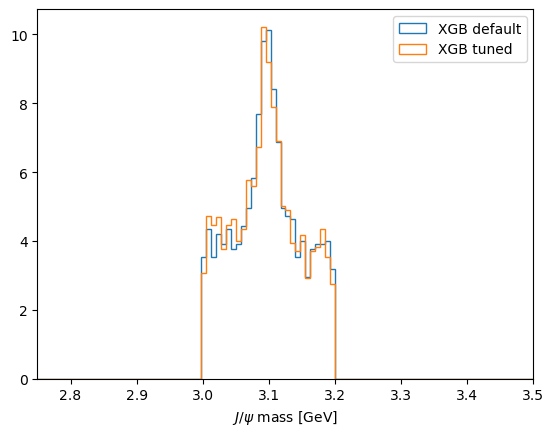

In [22]:
sig_df = data_df.query('(3.0 < Jpsi_M < 3.2)')
sig_bdt_cut = sig_df.query('XGB > %f' %bdt_cut )
plot_mass(sig_bdt_cut, label='XGB default', norm=True)
sig_gs_cut = sig_df.query('XGBgs > %f' %bdt_gs_cut )
plot_mass(sig_gs_cut, label='XGB tuned', norm=True)
plt.legend(loc='best')

You can also choose a higher learning rate to perform course scans of your space and decrease it again to retrain your final model. If you can afford to, it might be best to include learning rate itself as a parameter in your grid. With some libraries you can specify your choice of kernel. Both these choices will impact your optimal maximum number of iterations, so setting it sufficiently high and using early stopping might be a good strategy.

For less exhaustive and non-discritised methods try smart combinations of the following to perform adaptive scans or build your own:
*   sklearn.model_selection.RandomizedSearchCV
*   sklearn.model_selection.GridSearchCV

Moving to higher dimentional optimisation problems may require more sophisticated solutions:
*   skopt.BayesSearchCV
*   hyperopt.tpe

Full stats plots saved here: bit.ly/LHCb_XGB_Tuning
Run with full stats by removing entrystop at max_events in cell 8.

In [23]:
# Final lesson time and processing time check
print("Notebook real time --- %s seconds ---" % (time.time() - stt))
print("Notebook CPU time --- %s seconds ---" % (time.process_time() - stc))

Notebook real time --- 265.9296314716339 seconds ---
Notebook CPU time --- 180.03033820000002 seconds ---
